<center>

<h1 style="font-size: 40px;">Neural Network</h1>

</center>

The goal of the exercise is to implement a multilayer perceptron along with a chosen gradient-based optimization algorithm with backpropagation. The learning rate α should be chosen as the optimization parameter. Then, the multilayer perceptron should be trained to classify the [diabetes](https://archive.ics.uci.edu/dataset/34/diabetes) dataset. In both cases, appropriate ranges for optimization should be chosen. The training should be conducted following good ML practices (splitting into training and testing sets) and using metrics (ready-made solutions can be used):
- Precision
- Recall
- ROC curve

In [ ]:
%pip install pandas
%pip install ipython
%pip install ipympl
%pip install tabulate
%pip install ipywidgets
%pip install seaborn
%pip install numpy
%pip install scikit-learn
%matplotlib widget

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from datetime import datetime
import os

%matplotlib inline

Splitting time into 4 time frames to reduce the number of input data.

In [13]:
def categorize_time(time_str):
    time = datetime.strptime(time_str, '%H:%M')
    if time.hour >= 6 and time.hour < 10:
        return 'Breakfast'
    elif time.hour >= 10 and time.hour < 14:
        return 'Lunch'
    elif time.hour >= 14 and time.hour < 20:
        return 'Dinner'
    else:
        return 'Bedtime'

We merge the data into a single DataFrame.

In [14]:

folder_path = './Diabetes-Data'
combined_data = pd.DataFrame()
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    current_data = pd.read_csv(file_path, delimiter='\t', header=None)
    combined_data = pd.concat([combined_data, current_data], ignore_index=True)

df = combined_data


In [15]:
X = df.iloc[:,[0,1,3]]
X = X.drop(columns=[0])
X.columns = ['Time', 'Value']
X['Time'] = X['Time'].apply(categorize_time)
X = pd.get_dummies(X,drop_first=False, columns=['Time', 'Value'])
X = X.to_numpy()
X = X.astype(int)

Y = pd.get_dummies(df[2], drop_first=False)
Y = Y.astype(int)
Y = np.array(Y)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [17]:
class Layer:
    def __init__(self, n_input, n_output, learning_rate):
        self.weights  = np.random.rand(n_input, n_output) * np.sqrt(1 / n_input)
        self.biases = np.random.rand(1, n_output)
        self.learning_rate = learning_rate
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def activate(self, input):
        self.input = input
        self.output = self.sigmoid(np.dot(input, self.weights) + self.biases)
        return self.output
    
    def backward(self, output_error, previous_layer_weights):
        output_error = np.dot(output_error, previous_layer_weights.T) if previous_layer_weights is not None else output_error
        d_weights = self.input.T.dot(output_error * self.sigmoid_derivative(self.output))
        self.weights += d_weights * self.learning_rate
        self.biases += np.sum(output_error * self.sigmoid_derivative(self.output), axis=0) * self.learning_rate
        return output_error

In [18]:
class NeuralNetwork:
    def __init__(self, layers, learning_rate):
        self.losses_tables = [[],[],[],[]]
        self.layers = []
        self.learning_rate = learning_rate
        layers_len = len(layers)
        for i in range(layers_len - 1):
            self.layers.append(Layer(layers[i], layers[i+1], learning_rate))

    def forward_pass(self, input):
        for layer in self.layers:
            input = layer.activate(input)
        return input
    
    def backward_propagation(self, y, output):
        output_error = y - output

        for i in reversed(range(len(self.layers))):
            output_error = self.layers[i].backward(output_error, self.layers[i+1].weights if i != len(self.layers) - 1 else None)    

            
    def train(self, X, y, epochs):
        loss_table = []
        mean_loss_table = []
        binary_loss_table = []
        huber_loss_table = []
        for i in range(epochs):
            for j in range(len(X)):
                output = self.forward_pass(X[j:j+1])
                self.backward_propagation(y[j:j+1], output)
            loss = self.categorical_cross_entropy(y, output)
            mean_loss = self.mean_squared_error(y, output)
            binary_loss = self.binary_cross_entropy(y, output)
            huber_loss = self.huber_loss(y, output)
            loss_table.append(loss)
            mean_loss_table.append(mean_loss)
            binary_loss_table.append(binary_loss)
            huber_loss_table.append(huber_loss)
        self.losses_tables[0] = loss_table
        self.losses_tables[1] = mean_loss_table
        self.losses_tables[2] = binary_loss_table
        self.losses_tables[3] = huber_loss_table
    
    def predict_proba(self, X):
        return self.forward_pass(X)

    def categorical_cross_entropy(self, y_true, y_pred):
        y_pred_clipped = np.clip(y_pred, 1e-10, 1 - 1e-10)
        loss = -np.sum(y_true * np.log(y_pred_clipped), axis=1)
        return np.mean(loss)

    def binary_cross_entropy(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    def mean_squared_error(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)
    
    def huber_loss(self,y_true, y_pred, delta=1.0):
        error = y_true - y_pred
        is_small_error = np.abs(error) <= delta
        squared_loss = np.square(error) / 2
        linear_loss = delta * (np.abs(error) - delta / 2)
        return np.where(is_small_error, squared_loss, linear_loss).mean()
    
    def plot_roc_curves_multi_label(self, X, y_true):
        predictions = self.predict_proba(X)
        
        plt.figure(figsize=(10, 6))
        
        for i in range(y_true.shape[1]):
            fpr, tpr, _ = roc_curve(y_true[:, i], predictions[:, i])
            roc_auc = auc(fpr, tpr)
            
            plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
        plt.legend(loc='lower right')
        plt.show()

In [19]:
nn = NeuralNetwork([X.shape[1], 50, 50, Y.shape[1]], 0.01)
nn.train(X_train, y_train, 10)
predictions = nn.forward_pass(X_test)

Accuracy and precision achieved with 2 hidden layers of 50 neurons each.

In [20]:
best_predictions = np.zeros_like(predictions)
best_predictions[np.arange(len(predictions)), predictions.argmax(1)] = 1

print('Accuracy: ', metrics.accuracy_score(y_test, best_predictions))
print('Precision: ', metrics.precision_score(y_test, best_predictions, average='weighted'))

Accuracy:  0.6183153938151376
Precision:  0.47369997454747625


/home/mxn/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
# plotting loss over time curve
def plot_loss(loss_table, title):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(loss_table)), loss_table)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss over time - {title}')
    plt.xticks(range(len(loss_table)))
    plt.show()

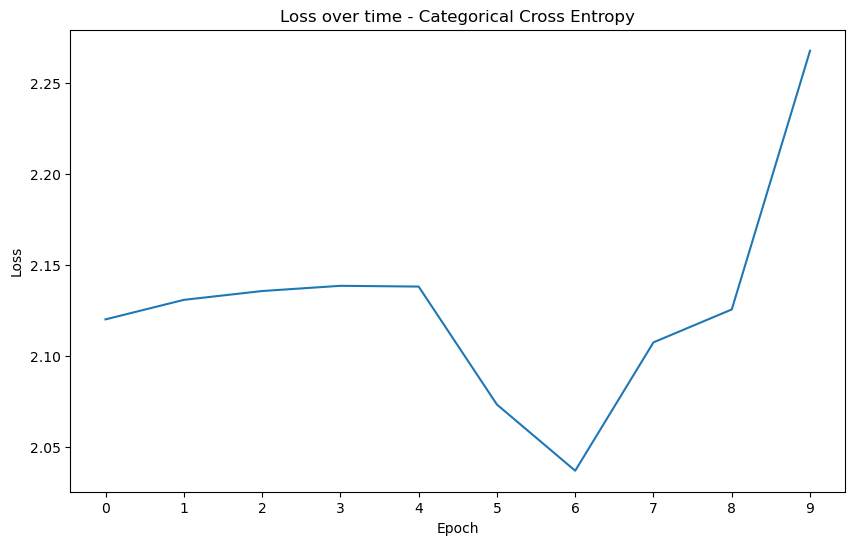

In [22]:
plot_loss(nn.losses_tables[0], 'Categorical Cross Entropy')

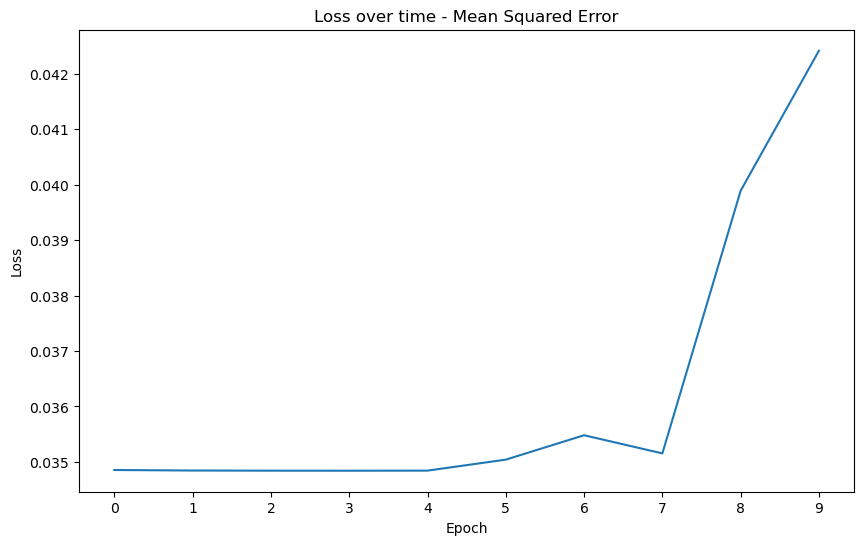

In [23]:
plot_loss(nn.losses_tables[1], 'Mean Squared Error')

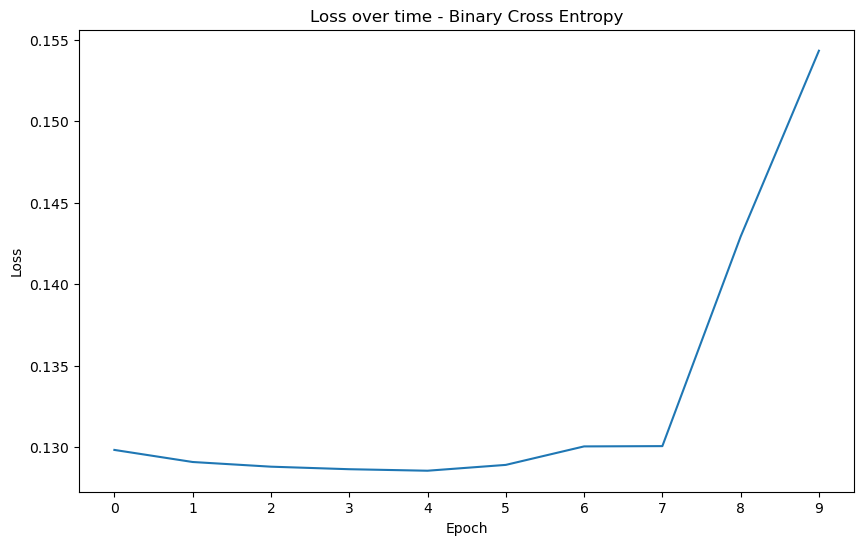

In [24]:
plot_loss(nn.losses_tables[2], 'Binary Cross Entropy')

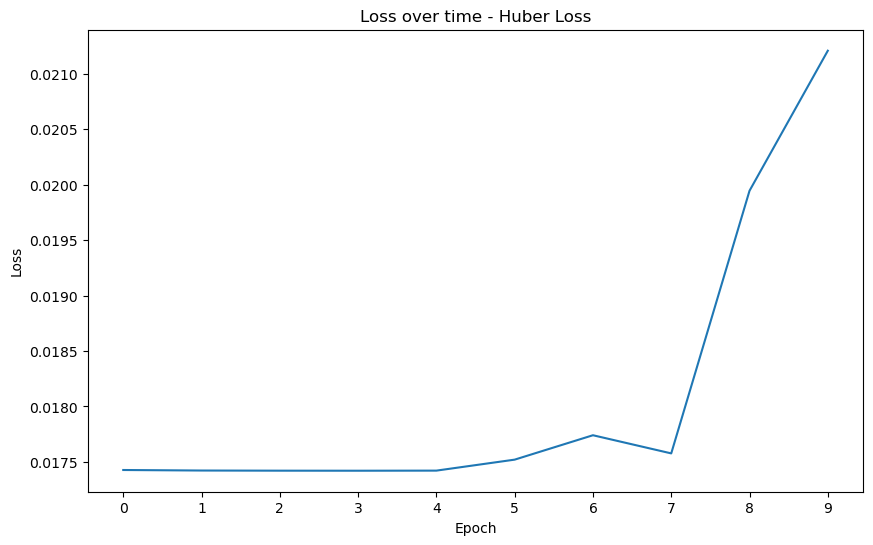

In [25]:
plot_loss(nn.losses_tables[3], 'Huber Loss')   

ROC curve for each output

/home/mxn/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/mxn/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


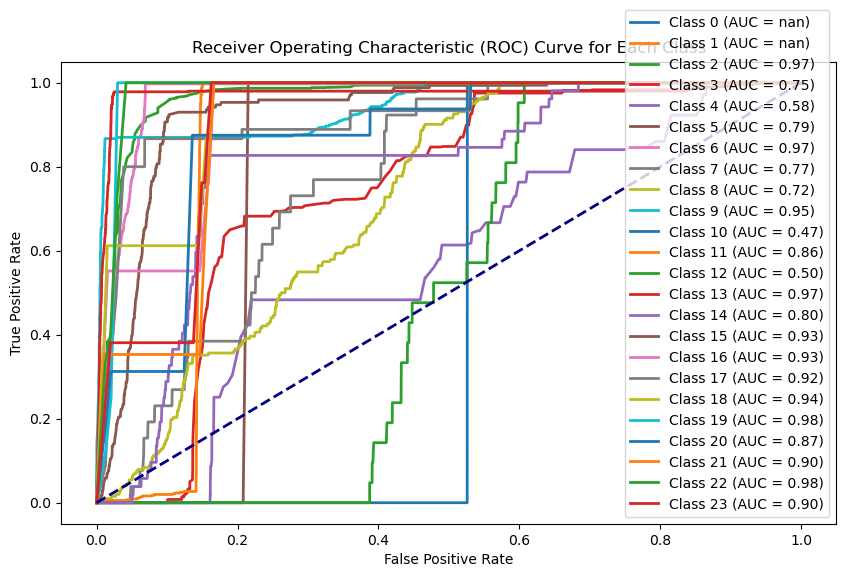

In [26]:
nn.plot_roc_curves_multi_label(X_test, y_test)

Heatmap comparing accuracy across learning rates and number of iterations

In [27]:
def accuracy_lr_ep_heatmap(learning_rates, epochs):
    accuracy_matrix = np.zeros((len(learning_rates), len(epochs)))
    for i, lr in enumerate(learning_rates):
        for j, ep in enumerate(epochs):
            nn = NeuralNetwork([X.shape[1], 100, Y.shape[1]], lr)
            nn.train(X_train, y_train, ep)
            predictions = nn.forward_pass(X_test)
            best_predictions = np.zeros_like(predictions)
            best_predictions[np.arange(len(predictions)), predictions.argmax(1)] = 1

            accuracy_matrix[i, j] = metrics.accuracy_score(y_test, best_predictions)

    plt.figure(figsize=(10, 6))
    sns.heatmap(accuracy_matrix, annot=True, xticklabels=epochs, yticklabels=learning_rates, fmt='.2f', cmap='Blues')
    plt.xlabel('Number of epochs')
    plt.ylabel('Learning rate')
    plt.title('Accuracy heatmap')
    plt.xticks(np.arange(len(epochs)), epochs)
    plt.yticks(np.arange(len(learning_rates)), learning_rates)
    plt.show()


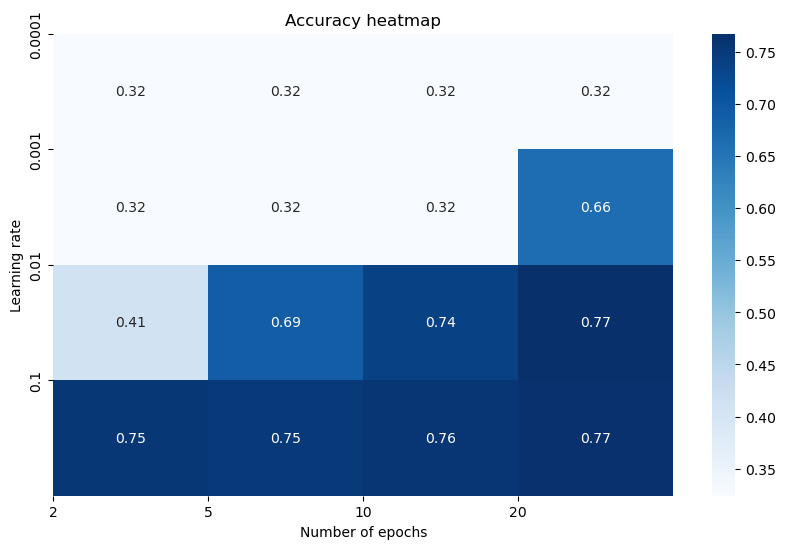

In [28]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]
epochs = [2, 5, 10, 20]


accuracy_lr_ep_heatmap(learning_rates, epochs)


The algorithm requires a sufficiently large number of iterations to compute accurate results. By decreasing the learning rate, we need to increase the number of iterations to obtain correct results.

We can observe that using a large learning rate allows us to achieve high accuracy with just a few iterations.

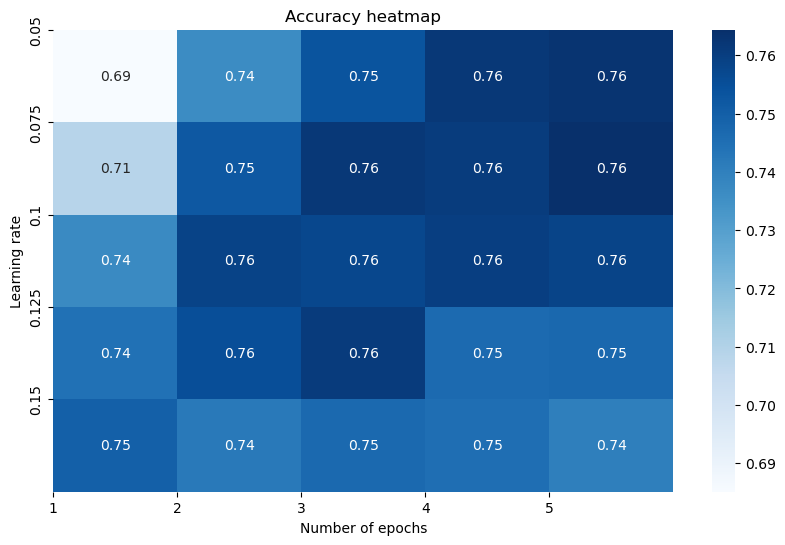

In [29]:
learning_rates = [0.05, 0.075, 0.1, 0.125, 0.15]
epochs = [1, 2, 3, 4, 5]

accuracy_lr_ep_heatmap(learning_rates, epochs)

A grid search with smaller values of learning rate and number of iterations shows that the most accurate results lie along the line where the ratio $lr/ep\approx 0.025$.

In [30]:
def accuracy_lines_plot(learning_rate, epochs, lines):
    accuracy = []
    for line in lines:
        X_shorted = X[:line]
        Y_shorted = Y[:line]
        X_train, X_test, y_train, y_test = train_test_split(X_shorted, Y_shorted, test_size=0.2, random_state=0)
        nn = NeuralNetwork([X.shape[1], 100, Y.shape[1]], learning_rate)
        nn.train(X_train, y_train, epochs)
        predictions = nn.forward_pass(X_test)
        best_predictions = np.zeros_like(predictions)
        best_predictions[np.arange(len(predictions)), predictions.argmax(1)] = 1

        accuracy.append(metrics.accuracy_score(y_test, best_predictions))

    plt.figure(figsize=(10, 6))
    plt.plot(lines, accuracy)
    plt.xlabel('Number of data lines')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for different number of test data')
    plt.show()

Plot of accuracy as a function of the number of data lines.

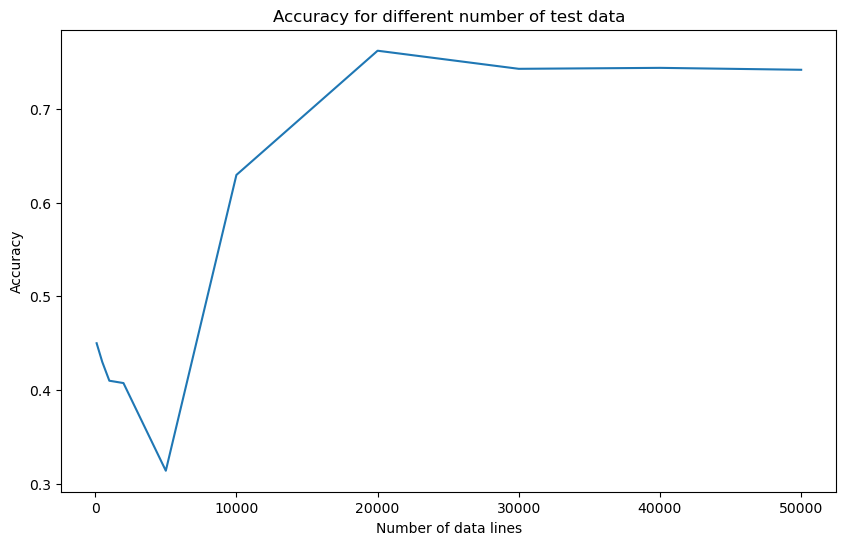

In [31]:
lines = [100, 500, 1000, 2000, 5000, 10000, 20000, 30000, 40000, 50000]
accuracy_lines_plot(0.01, 10, lines)

In [34]:
clf = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=100, alpha=0.01, solver='sgd')
clf.fit(X_train, y_train)
y_pred_sklearn = clf.predict(X_test)

print('Our model:')
print('Accuracy: ', metrics.accuracy_score(y_test, best_predictions))
print('Precision: ', metrics.precision_score(y_test, best_predictions, average='weighted'))

print('Sklearn model:')
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_sklearn))
print('Precision: ', metrics.precision_score(y_test, y_pred_sklearn, average='weighted'))

Our model:
Accuracy:  0.6183153938151376
Precision:  0.47369997454747625
Sklearn model:
Accuracy:  0.7016914402870323
Precision:  0.699864993431436


/home/mxn/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mxn/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mxn/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Our model achieves similar accuracy; we can increase it by changing appropriate hyperparameters.